20191204 having one last go at the g140m extractions

In [100]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.table import Table
from astropy.io import ascii
import astropy.units as u
import astropy.constants as const
from scipy.interpolate import interpolate
from craftroom import resample
import stistools
from astropy.convolution import convolve, Box1DKernel

#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20


In [186]:
datapath = 'raw_data/'
outpath = 'new_x1ds/'
flts = glob.glob(datapath + '*flt.fits*')
raws = glob.glob(datapath + '*raw.fits*')
oref="${CRDS_PATH}/references/hst/oref/"


In [3]:
#check it works
#stistools.x1d.x1d(flts[0], output=outpath+"test", verbose=True, trailer=outpath+"test.trl")

In [4]:
#data = fits.getdata(outpath+'test.fits')
#plt.plot(data[0]['WAVELENGTH'], data[0]['FLUX'])

In [14]:
centab = Table.read('new_trace_centers.ecsv')
#centab

In [6]:
def build_trace_grid(SPTRCTAB, grating, cenwave):
    """
    Extends a grid of trace displacements to cover all y positions
    """
    data = fits.getdata(SPTRCTAB, 1)
    tracedata = data[(data['OPT_ELEM']==grating) & (data['CENWAVE'] == cenwave)]
    all_y = np.arange(len(tracedata[0]['A2DISPL']))
    grid = interpolate.interp1d(tracedata['A2CENTER'], tracedata['A2DISPL'], axis=0, fill_value='extrapolate')(all_y)
    tracegrid = [a+b for a, b in zip(grid, all_y)] 
    return tracegrid

def get_a2center(x, y, tracegrid):
    """
    get the trace a2center at a1center
    """
    xcol = np.array(tracegrid)[:,int(x)]
    xind = (np.abs(xcol - y)).argmin()
    a2center = xind + 1 #calstis is 1-indexed 
    return a2center


In [188]:
for fl in glob.glob(outpath+'*.fits'):
    os.remove(fl)

for i, flt in enumerate(raws):
    hdr = fits.getheader(flt, 0)
    #build trace grid
    if i == 0:
        SPTRCTAB = hdr['SPTRCTAB']
        grating = hdr['OPT_ELEM']
        cenwave = hdr['CENWAVE']
        tracegrid = build_trace_grid('/home/david/crds_cache/references/hst/oref/'+SPTRCTAB[5:], grating, cenwave)
        
    rootname =  hdr['ROOTNAME']
    if rootname in centab['ROOTNAME']:
        rootarg = np.argwhere(centab['ROOTNAME']==rootname)[0][0]
        if centab['UNCERTAIN'][rootarg] < 3:#== 0.0:
            #adjust measured a2 center to central point
            x = centab['XCOL'][rootarg]
            y = centab['A2CENTER'][rootarg]
            a2center = get_a2center(x,y, tracegrid)
           # plt.figure(rootname)
            stistools.x1d.x1d(flt, output=outpath+rootname+'_raw_x1d.fits', verbose=False, trailer='trl_files/'+rootname+'.trl',a2center=a2center,maxsrch=0)
           # data = fits.getdata(outpath+rootname+'_new_x1d.fits')[0]
           # plt.step(data['WAVELENGTH'], data['FLUX'],where='mid',label='center')
            #stistools.x1d.x1d(flt, output=outpath+rootname+'_plus_x1d.fits', verbose=False, trailer='trl_files/'+rootname+'.trl',a2center=a2center+1,maxsrch=0)
            #data = fits.getdata(outpath+rootname+'_plus_x1d.fits')[0]
            #plt.step(data['WAVELENGTH'], data['FLUX'], where='mid', label='plus', ls='--', zorder=-1)
            #stistools.x1d.x1d(flt, output=outpath+rootname+'_minus_x1d.fits', verbose=False, trailer='trl_files/'+rootname+'.trl',a2center=a2center-1,maxsrch=0)
            #data = fits.getdata(outpath+rootname+'_minus_x1d.fits')[0]
            #plt.step(data['WAVELENGTH'], data['FLUX'], where='mid', label='minus', ls='--', zorder=-1)
            #plt.xlim(1210, 1220)
            #plt.legend()
            #plt.savefig('a2testplots/'+rootname+'_a2test.png')
            #plt.close()
new_x1ds = glob.glob(outpath+'*new_x1d*')
print(len(new_x1ds))  

new_raws = glob.glob(outpath+'*raw_x1d*')
print(len(new_raws))  

92
3


In [8]:
#grab the current state of the art...
cspec = Table.read('extracted_spectra/hlsp_muscles_hst_stis_2mass-j23062928-0502285_g140m_v1_component-spec.ecsv')
wc, fc, ec = cspec['WAVELENGTH'], cspec['FLUX'], cspec['ERROR']

In [38]:
def no_zero_errors(flux, error):
    """
    Corrects instances where negative flux measurements have very small errors
    """
    e_new = error
    for i in range(len(error)):
        if flux[i] < 0.0 and error[i] < 0.1*abs(flux[i]):
            e_new[i] = abs(flux[i])
    return e_new

def new_coadd(f_array, e_array):
    weights = 1 / (e_array**2)
    flux = np.average(f_array, axis =0, weights = weights)
    var = 1 / np.sum(weights, axis=0)
    rcs = np.sum(((flux - f_array)**2) * weights, axis=0) / (len(f_array)-1)
    error = (var * rcs)**0.5
    return flux, error

/home/david/anaconda3/envs/astroconda/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in true_divide
  if sys.path[0] == '':


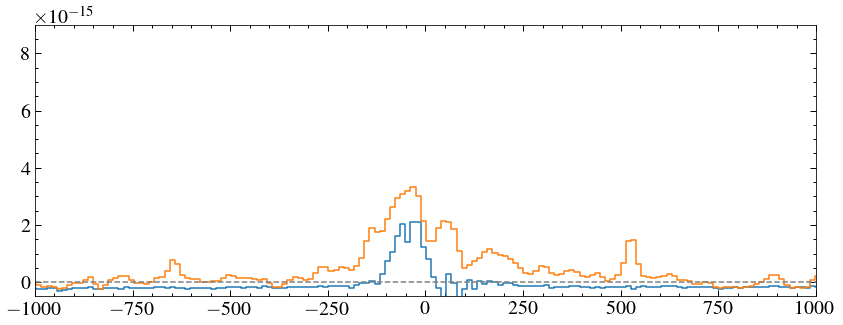

5.6560286e-15


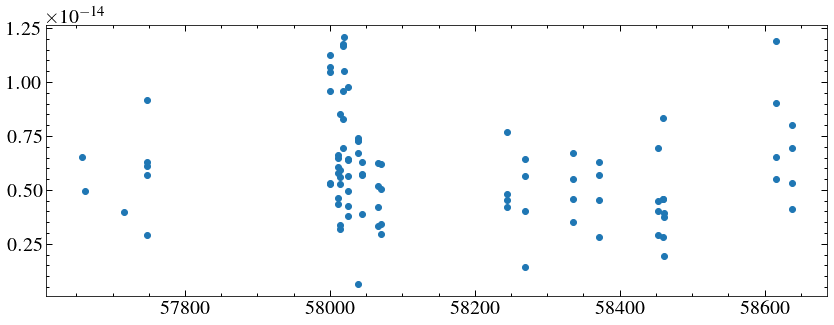

In [120]:


f_new = []
e_new = []

rejects = Table.read('clean_spectra.ecsv')['KEEP']
dates = []
lyfluxes = []
peaks = []
for i, x in enumerate(new_x1ds):
    dates.append(fits.getheader(x,0)['TEXPSTRT'])
    data = fits.getdata(x, 1)[0]
    first = True

    #if rejects[i]== 0.0:
    wi, fi, ei = data['WAVELENGTH'], data['FLUX'], data['ERROR']
    v = (wi*u.AA).to(u.km/u.s, equivalencies= u.doppler_optical(1215.44*u.AA))
    mask = (v >= -200*u.km/u.s) & (v <= -60*u.km/u.s)
    lyfluxes.append(np.trapz(fi[mask], v[mask].value))
    peaks.append(np.max(fi[mask]))
    ei = no_zero_errors(fi, ei) 
    if  first:
        w_new = wi
       # w_new = np.arange(w_new[5], w_new[-6], np.mean(np.diff(w_new)))

        first = False
    else:
        #fi = interpolate.interp1d(data['WAVELENGTH'], fi, fill_value='extrapolate')(w_new)
        #bintogrid(x, y, unc=None, newx=None, dx=None, weighting='inversevariance', drop_nans=True)
        wi, fi, ei  = resample.bintogrid(wi, fi, newx=w_new, dx=ei)
        #ei = interpolate.interp1d(data['WAVELENGTH'], ei, fill_value='extrapolate')(w_new)
    f_new.append(fi)
    e_new.append(ei)

#f_av = np.average(f_new, axis=0)
w_dop = (w_new*u.AA).to(u.km/u.s, equivalencies= u.doppler_optical(1215.44*u.AA))
#plt.step(w_dop, f_av, where='mid')

f_av, e_av = new_coadd(np.array(f_new), np.array(e_new))
plt.step(w_dop, f_av, where='mid')

smooth =2
f_smooth = [convolve(flux,Box1DKernel(smooth)) for flux in np.array(f_new)]
e_smooth = [convolve(error,Box1DKernel(smooth))/(smooth**0.5) for error in np.array(e_new)]
#f_av, e_av = new_coadd(np.array(f_smooth), np.array(e_smooth))
f_av = np.mean(f_smooth, axis=0)
plt.step(w_dop, f_av, where='mid')


#plt.step(wc, fc, where='mid', zorder=-1)
plt.axhline(0, ls='--', c='0.5')
#plt.xlim(1212, 1218)
plt.xlim(-1000, 1000)
plt.ylim(-0.5e-15, 9e-15)
plt.show()
plt.errorbar(dates, peaks, ls='none', marker='o')
print(np.median(peaks))

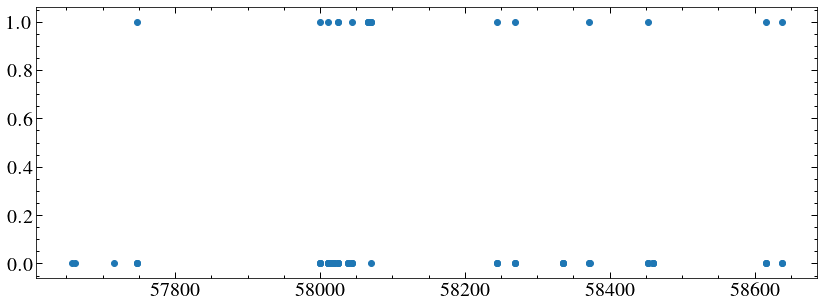

In [54]:
reject_tab = Table.read('clean_spectra.ecsv')
plt.scatter(reject_tab['DATE'], reject_tab['KEEP'])

(-300, 200)

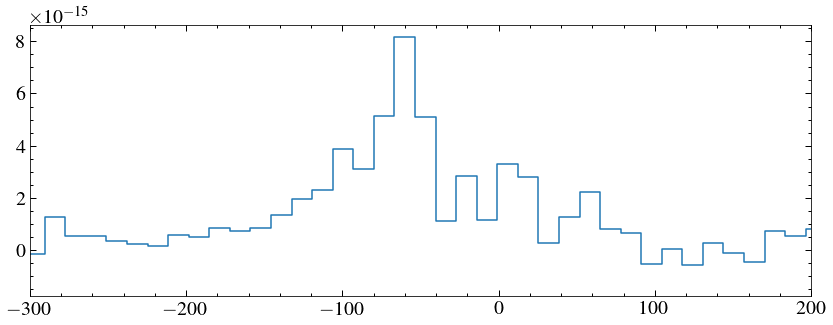

In [137]:
dargs = np.argsort(np.array(dates))
xsorted = np.array(new_x1ds)[dargs]
fb = []
for i, x in enumerate(xsorted[0:2]):
    data = fits.getdata(x, 1)[0]
    wi, fi = data['WAVELENGTH'], data['FLUX']
    
    
    if i == 0:
        wb = wi
        fb.append(fi)
    else:
        fi = interpolate.interp1d(wi, fi, fill_value='extrapolate')(wb)
        fb.append(fi)
    vdop = (wb*u.AA).to(u.km/u.s, equivalencies= u.doppler_optical(1215.44*u.AA))
  #  plt.plot(vdop, fi)
        
vdop = (wb*u.AA).to(u.km/u.s, equivalencies= u.doppler_optical(1215.44*u.AA))
fb = np.mean(fb, axis=0)
plt.step(vdop, fb)
plt.xlim(-300, 200)
#plt.plot(w_dop, f_av)
#plt.axhline(8e-15)
#plt.plot(w_dop, f_av)
    #plt.show()

Ok so we're nearly exactly recreating Borrier's work. What's up with the rest of it then?

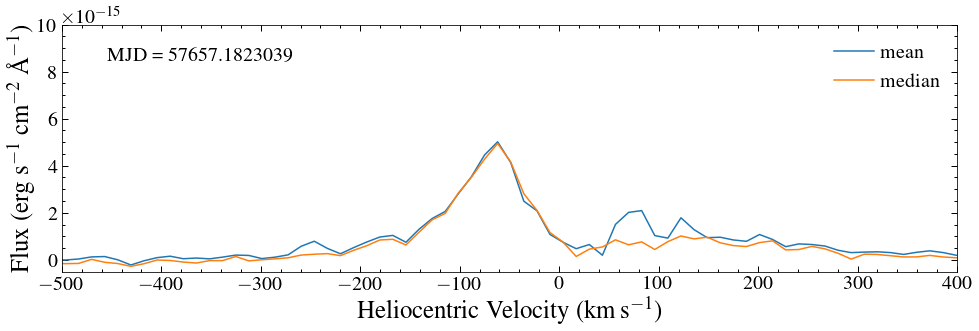

In [178]:
from matplotlib.animation import FuncAnimation

datesorted = np.array(dates)[dargs]
fig, ax = plt.subplots(nrows=1, ncols=1)
#fig.set_tight_layout(True)

fluxes = []



data = fits.getdata(xsorted[0], 1)[0]
w1, f1, e1 = data['WAVELENGTH'], data['FLUX'], data['ERROR']
wv = (wi*u.AA).to(u.km/u.s, equivalencies= u.doppler_optical(1215.44*u.AA))
line1, = ax.plot(wv,f1, label ='mean')
line2, = ax.plot(wv,f1, label ='median')
ax.set_xlim(-500, 400)
ax.set_ylim(-0.5e-15, 10e-15)
ax.legend()
ax.set_xlabel('Heliocentric Velocity (km\,s$^{-1}$)', size=25)
ax.set_ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)',size=25)
date_text = ax.text(0.05, 0.85, 'MJD = {0}'.format(datesorted[0]), transform=ax.transAxes)
#label =ax.annotate('MJD = {0}'.format(datesorted[0]), (0.05, 0.85), xycoords = ('axes fraction'))

fig.set_tight_layout(True)
def update(i):
    global fluxes, w1
    data = fits.getdata(xsorted[i], 1)[0]
    wi, fi, ei = data['WAVELENGTH'], data['FLUX'], data['ERROR']
    fi = interpolate.interp1d(wi, fi, fill_value='extrapolate')(w1)
    fluxes.append(fi)
    f_av = np.mean(fluxes, axis=0)
    line1.set_ydata(f_av)
    f_med = np.median(fluxes, axis=0)
    line2.set_ydata(f_med)
    date_text.set_text('MJD = {0}'.format(datesorted[i]))
    #label = ax.annotate('MJD = {0}'.format(datesorted[i]), (0.05, 0.85), xycoords = ('axes fraction'))
    
    return ax, line1, line2, date_text


anim = FuncAnimation(fig, update, frames=np.arange(len(xsorted)), interval=250)
anim.save('test.gif', dpi=80, writer='imagemagick')
plt.show()



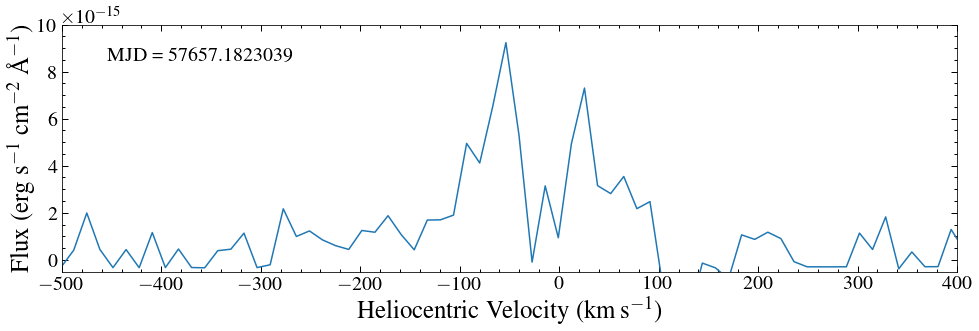

In [209]:
fig, ax = plt.subplots(nrows=1, ncols=1)
data = fits.getdata(xsorted[0], 1)[0]
w1, f1, e1 = data['WAVELENGTH'], data['FLUX'], data['ERROR']
wv = (wi*u.AA).to(u.km/u.s, equivalencies= u.doppler_optical(1215.44*u.AA))
line1, = ax.plot(wv,f1)
ax.set_xlim(-500, 400)
ax.set_ylim(-0.5e-15, 10e-15)
ax.set_xlabel('Heliocentric Velocity (km\,s$^{-1}$)', size=25)
ax.set_ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)',size=25)
date_text = ax.text(0.05, 0.85, 'MJD = {0}'.format(datesorted[0]), transform=ax.transAxes)
#label =ax.annotate('MJD = {0}'.format(datesorted[0]), (0.05, 0.85), xycoords = ('axes fraction'))

fig.set_tight_layout(True)
def update(i):
    data = fits.getdata(xsorted[i], 1)[0]
    wi, fi, ei = data['WAVELENGTH'], data['FLUX'], data['ERROR']
    wv = (wi*u.AA).to(u.km/u.s, equivalencies= u.doppler_optical(1215.44*u.AA))
    line1.set_xdata(wv)
    line1.set_ydata(fi)
    date_text.set_text('MJD = {0}'.format(datesorted[i]))
    #label = ax.annotate('MJD = {0}'.format(datesorted[i]), (0.05, 0.85), xycoords = ('axes fraction'))
    
    return ax, line1, date_text


anim = FuncAnimation(fig, update, frames=np.arange(len(xsorted)), interval=250)
anim.save('allspec.gif', dpi=80, writer='imagemagick')
plt.show()


Just looking at the Mega-Muscles g140m observations?

In [206]:


#stistools.x1d.x1d(datapath+'odlm41020_raw.fits', output=outpath+'odlm41020_new_x1d.fits', verbose=False, trailer='trl_files/odlm41020.trl',a2center=901,maxsrch=0)
stistools.calstis.calstis(datapath+'odlm41020_raw.fits', outroot=outpath+'odlm41020_new', verbose=False, trailer='trl_files/odlm41020.trl')


0

In [204]:
ourroots = ['odlm41020','odlm41030','odlm41040','odlm41050']
our_x1ds = glob.glob(outpath+'*odlm*new_x1d*')

f_new = []
e_new = []


for i, x in enumerate(our_x1ds):
    #dates.append(fits.getheader(x,0)['TEXPSTRT'])
    data = fits.getdata(x, 1)[0]
    rootname = fits.getheader(x)['ROOTNAME']
    first = True

    if rootname in ourroots:
        print(rootname)
        wi, fi, ei = data['WAVELENGTH'], data['FLUX'], data['ERROR']
        v = (wi*u.AA).to(u.km/u.s, equivalencies= u.doppler_optical(1215.44*u.AA))
        mask = (v >= -200*u.km/u.s) & (v <= -60*u.km/u.s)
        lyfluxes.append(np.trapz(fi[mask], v[mask].value))
        peaks.append(np.max(fi[mask]))
        ei = no_zero_errors(fi, ei) 
        if  first:
            w_new = wi
           # w_new = np.arange(w_new[5], w_new[-6], np.mean(np.diff(w_new)))

            first = False
        else:
            #fi = interpolate.interp1d(data['WAVELENGTH'], fi, fill_value='extrapolate')(w_new)
            #bintogrid(x, y, unc=None, newx=None, dx=None, weighting='inversevariance', drop_nans=True)
            wi, fi, ei  = resample.bintogrid(wi, fi, newx=w_new, dx=ei)
            #ei = interpolate.interp1d(data['WAVELENGTH'], ei, fill_value='extrapolate')(w_new)
        f_new.append(fi)
        e_new.append(ei)

    #f_av = np.average(f_new, axis=0)
w_dop = (w_new*u.AA).to(u.km/u.s, equivalencies= u.doppler_optical(1215.44*u.AA))
#plt.step(w_dop, f_av, where='mid')

f_av, e_av = new_coadd(np.array(f_new), np.array(e_new))
plt.step(w_dop, f_av, where='mid')

f_av = np.average(f_new, axis=0)
plt.step(w_dop, f_av, where='mid')

plt.xlim(-500, 400)

odlm41050
odlm41040
odlm41020
odlm41030


/home/david/anaconda3/envs/astroconda/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in true_divide
  if sys.path[0] == '':
/home/david/anaconda3/envs/astroconda/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':


ValueError: operands could not be broadcast together with shapes (1024,) (2048,) 